In [271]:
import os
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable

In [272]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((50, 200)),  # Resize to a fixed size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize([0.5], [0.5])  # Normalize with ImageNet stats
])

# Custom dataset class'
all_classes = []
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        # Extract the label from the filename (without extension)
        label = os.path.splitext(os.path.basename(img_path))[0]
        all_classes.append(label)
        # Convert label to a tensor (e.g., using a simple encoding scheme)
        label_tensor = torch.tensor([ord(char) for char in label], dtype=torch.long)

        return image, label_tensor[4]

""" class FlattenedImageDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.flattened_data = self.flatten_dataset()

    def flatten_dataset(self):
        flattened_data = []
        for i in range(len(self.base_dataset)):
            image, label_tensor = self.base_dataset[i]
            for label in label_tensor:
                flattened_data.append((image, label))
        return flattened_data

    def __len__(self):
        return len(self.flattened_data)

    def __getitem__(self, idx):
        return self.flattened_data[idx]
 """

# Create the dataset
dataset = CustomImageDataset(root_dir=os.path.expanduser('~/Downloads/captcha_project/captcha'), transform=transform)



""" dataset = FlattenedImageDataset(dataset)
if len(dataset) == 0:
    print("Dataset is empty")
# Print out the labels (base names) in the dataset
for idx, (image, label) in enumerate(dataset):
    print(f"Index: {idx}, Label: {label}")
# Create DataLoader objects """
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Example of iterating through the DataLoader
for batch_idx, (images, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx}, Labels: {labels}")
for item in all_classes:
    print(item)

Batch 0, Labels: tensor([103, 110,  98,  54, 102, 100, 110,  51,  56, 110,  56,  53, 101, 110,
         53, 110,  99,  54, 102, 100,  53,  55,  50,  55, 120,  53, 119, 120,
        110, 112,  56, 103, 110,  56, 110,  53, 110, 103, 100,  52, 102,  53,
         98, 119, 103, 102, 110,  56, 103, 121,  50, 110, 110,  98, 109,  54,
        110,  51,  51, 121,  51,  99,  56,  53])
Batch 1, Labels: tensor([ 56, 110, 112,  51, 120,  51, 100,  51, 109,  54, 119,  52, 119, 109,
        110, 121, 121, 109, 110,  51,  55,  51,  51, 110, 119,  54, 119, 112,
         52,  99,  53,  56, 110, 110, 102,  55, 110, 119,  56,  51, 110,  98,
         53, 109, 112,  98,  54,  53,  53,  98,  54,  50, 120,  52, 121,  52,
         54,  51,  56,  98, 100,  50, 102,  51])
Batch 2, Labels: tensor([110,  56, 101,  52, 101, 110, 110, 120,  51, 102,  50, 120,  55, 110,
         52, 109,  50,  50,  51,  54,  52,  56,  50,  53, 110,  56,  54,  53,
         51, 101, 110,  98,  99, 103, 112,  51, 109, 102, 121,  55, 100

In [273]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

torch.manual_seed(42)

# Step 4: Use random_split to split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Step 5: Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Extract the indices for the test dataset
test_indices = test_dataset.indices




for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
print(f"Number of samples in train_loader: {len(train_loader.dataset)}")
print(f"Number of samples in train_loader: {len(test_loader.dataset)}")


Shape of X [N, C, H, W]: torch.Size([64, 1, 50, 200])
Shape of y: torch.Size([64]) torch.int64
Number of samples in train_loader: 856
Number of samples in train_loader: 214


In [274]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24 * 47 * 9, 180)  # 180 output layers for 5 characters, each with 36 possible values

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))
        #print(f"Shape after conv1: {output.shape}")
        
        output = F.relu(self.bn2(self.conv2(output)))
        #print(f"Shape after conv2: {output.shape}")
        
        output = self.pool(output)
        #print(f"Shape after first pool: {output.shape}")
        
        output = F.relu(self.bn4(self.conv4(output)))
        #print(f"Shape after conv4: {output.shape}")
        
        output = F.relu(self.bn5(self.conv5(output)))
        #print(f"Shape after conv5: {output.shape}")
        
        output = self.pool(output)
        #print(f"Shape after second pool: {output.shape}")
        
        output = output.view(-1, 24 * 47 * 9)  # Ensure this matches the output size
        #print(f"Shape after flattening: {output.shape}")
        
        output = self.fc1(output)
        
        return output
# Instantiate a neural network model 
model = Network()

In [275]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [276]:
def saveModel():
    downloads_path = os.path.expanduser("~/Downloads/captcha_project/myFifthModel.pth")
    torch.save(model.state_dict(), downloads_path)
    if os.path.exists(downloads_path):
        print(f"Model successfully saved to {downloads_path}")
    else:
        print(f"Failed to save the model to {downloads_path}")

def save_test_loader_data(test_loader, model_name):
    all_images = []
    all_labels = []
    all_indices = []
    
    for batch_idx, (images, labels) in enumerate(test_loader):
        all_images.extend(images.numpy())
        all_labels.extend(labels.numpy())
        all_indices.extend([batch_idx * test_loader.batch_size + i for i in range(len(images))])
    
    # Create a directory for the model if it doesn't exist
    model_dir = os.path.expanduser(f"~/Downloads/captcha_project/{model_name}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Save images, labels, and indices
    torch.save(all_images, os.path.join(model_dir, 'test_images.pt'))
    torch.save(all_labels, os.path.join(model_dir, 'test_labels.pt'))
    torch.save(all_indices, os.path.join(model_dir, 'test_indices.pt'))
    print(f"Test loader data successfully saved to {model_dir}")

def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images.to(device))
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels.to(device)).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


In [277]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [278]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [279]:
# Function to test what classes performed well
def testClassess():
    class_correct = list(0. for i in range(number_of_labels))
    class_total = list(0. for i in range(number_of_labels))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(number_of_labels):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [280]:
if __name__ == "__main__":
    
    # Let's build our model
    train(5)
    print('Finished Training')

    # Test which classes performed well
    testAccuracy()
    # Let's load the model we just created and test the accuracy per label
    model = Network()
    path = "~/Downloads/captcha_project/myFifthModel.pth"
    model.load_state_dict(torch.load(path))

    # Test with batch of images
    testBatch()
    

The model will be running on cpu device
For epoch 1 the test accuracy over the whole test set is 7 %
Model successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel.pth
For epoch 2 the test accuracy over the whole test set is 43 %
Model successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel.pth
For epoch 3 the test accuracy over the whole test set is 55 %
Model successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel.pth
For epoch 4 the test accuracy over the whole test set is 63 %
Model successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel.pth
For epoch 5 the test accuracy over the whole test set is 63 %
Finished Training


/var/folders/7_/5fn5htf54wn_m3yp89hpzn_r0000gn/T/ipykernel_75631/3003885018.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


FileNotFoundError: [Errno 2] No such file or directory: '~/Downloads/captcha_project/myFifthModel.pth'

In [281]:
save_test_loader_data(test_loader, "myFifthModel")

Test loader data successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel


Image dimensions: 200x50 pixels


/var/folders/7_/5fn5htf54wn_m3yp89hpzn_r0000gn/T/ipykernel_75631/1010664760.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


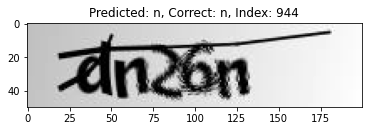

Image 0 - Index: 944, Predicted: n, Correct: n


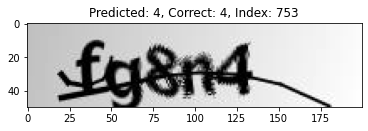

Image 1 - Index: 753, Predicted: 4, Correct: 4


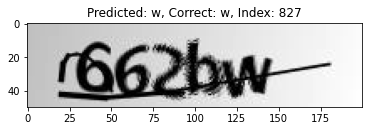

Image 2 - Index: 827, Predicted: w, Correct: w


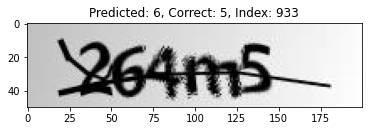

Image 3 - Index: 933, Predicted: 6, Correct: 5


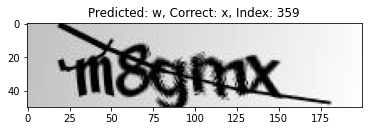

Image 4 - Index: 359, Predicted: w, Correct: x


In [282]:
model = Network()
path = os.path.expanduser("~/Downloads/captcha_project/myFifthModel.pth")
model.load_state_dict(torch.load(path))
model.eval()  # Set the model to evaluation mode
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(f"Image dimensions: {images[0].shape[2]}x{images[0].shape[1]} pixels")
# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Visualize the images and predictions
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

test_indices = test_dataset.indices


# Display the first 5 images, their predictions, and indices
for i in range(5):
    correct_label = chr(labels[i].item())
    predicted_label = chr(predicted[i].item())
    index = test_indices[i]
    imshow(images[i], f'Predicted: {predicted_label}, Correct: {correct_label}, Index: {index}')
    print(f"Image {i} - Index: {index}, Predicted: {predicted_label}, Correct: {correct_label}")

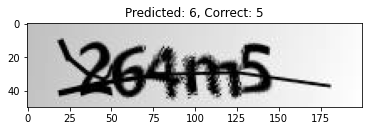

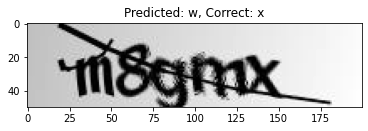

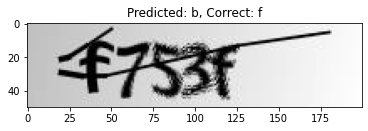

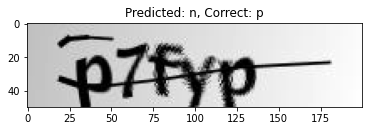

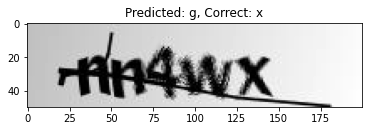

In [283]:
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_images.append(images[i])
                misclassified_labels.append(labels[i])
                misclassified_predictions.append(predicted[i])

# Visualize the misclassified examples
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

# Display the first 5 misclassified images and their predictions
for i in range(min(5, len(misclassified_images))):
    correct_label = chr(misclassified_labels[i].item())
    predicted_label = chr(misclassified_predictions[i].item())
    imshow(misclassified_images[i], f'Predicted: {predicted_label}, Correct: {correct_label}')

In [284]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_images = []
    all_indices = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu().numpy())
            all_indices.extend([batch_idx * test_loader.batch_size + i for i in range(len(images))])
    
    return all_predictions, all_labels, all_images, all_indices

Batch 0, Labels: tensor([102, 103, 102,  53, 102, 102,  99, 112, 110, 100, 103, 102, 120, 119,
        100,  52,  53, 110,  52, 100, 110, 102, 100, 109, 121,  52, 121,  55,
        112,  50,  56,  54, 112,  56,  51, 121,  52,  98,  50, 103,  56, 109,
         52,  99, 102, 102,  56, 120,  99, 121, 109, 119, 119, 102,  51,  99,
         50,  98,  55,  54,  54, 102,  50, 120])
Batch 1, Labels: tensor([ 56, 103,  55,  51, 109, 119, 103, 112, 119,  51,  50, 120,  55, 110,
         53, 110, 109,  51, 110,  98,  55, 100,  50,  52, 110, 102,  54, 110,
         51,  53, 119,  50, 121, 110,  51, 103,  50, 119, 119, 110, 121,  55,
        101, 110, 102, 102, 112, 100,  53,  51, 119,  98,  52, 119, 103,  50,
        109, 119,  52,  52, 109,  52,  52,  53])
Batch 2, Labels: tensor([ 56,  52, 103, 110, 120,  52,  56, 109, 103, 101,  54,  52,  52,  52,
         50,  53, 110,  55, 112, 120, 100, 120,  98, 120,  54, 110,  99, 102,
         56,  55, 103, 110, 109,  50,  52,  54, 101,  50,  56,  50,  56

/var/folders/7_/5fn5htf54wn_m3yp89hpzn_r0000gn/T/ipykernel_75631/2293934240.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.exp

Evaluating model 1
Evaluating model 2
Evaluating model 3
Evaluating model 4
Evaluating model 5


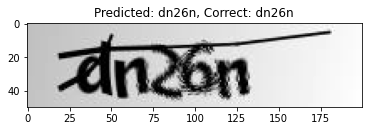

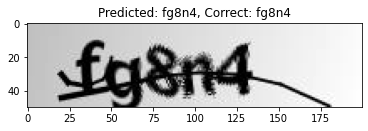

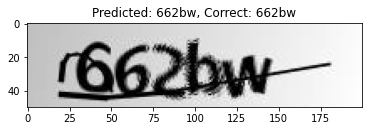

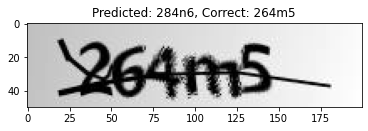

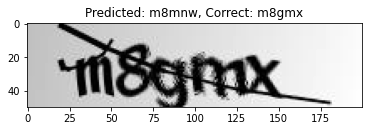

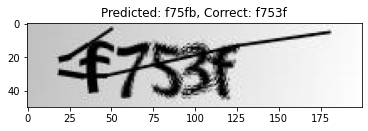

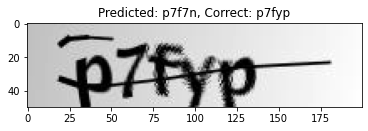

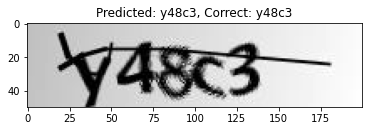

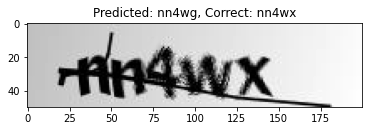

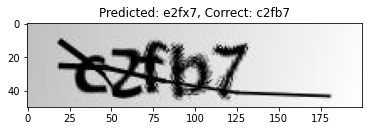

In [285]:
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_paths = [
    "~/Downloads/captcha_project/myFirstModel.pth",
    "~/Downloads/captcha_project/mySecondModel.pth",
    "~/Downloads/captcha_project/myThirdModel.pth",
    "~/Downloads/captcha_project/myFourthModel.pth",
    "~/Downloads/captcha_project/myFifthModel.pth"
]

models = []
for model_path in model_paths:
    model = Network().to(device)
    model.load_state_dict(torch.load(os.path.expanduser(model_path)))
    models.append(model)

all_model_predictions = []
all_labels = None
all_images = None
all_indices = None

test_loader_paths = [
    "~/Downloads/captcha_project/myFirstModel/test_labels.pt",
    "~/Downloads/captcha_project/mySecondModel/test_labels.pt",
    "~/Downloads/captcha_project/myThirdModel/test_labels.pt",
    "~/Downloads/captcha_project/myFourthModel/test_labels.pt",
    "~/Downloads/captcha_project/myFifthModel/test_labels.pt"
]

# Function to load labels from the specified paths
def load_labels(paths):
    labels_list = []
    for path in paths:
        # Expand the user path
        expanded_path = os.path.expanduser(path)
        # Load the labels
        labels = torch.load(expanded_path)
        # Append to the list
        labels_list.append(labels)
    return labels_list

# Load the labels
labels_list = load_labels(test_loader_paths)

# Print the loaded labels for verification
concatenated_correct = [''.join(chr(label[i]) for label in labels_list) for i in range(len(labels_list[0]))]

for i, model in enumerate(models):
    print(f"Evaluating model {i+1}")
    predictions, labels, images, indices = evaluate_model(model, test_loader, device)
    all_model_predictions.append(predictions)
    if all_labels is None:
        all_labels = labels  # Save labels from the first evaluation
    if all_images is None:
        all_images = images  # Save images from the first evaluation
    if all_indices is None:
        all_indices = indices  # Save indices from the first evaluation

# Convert labels to strings if they are not sequences
if isinstance(all_labels[0], np.int64):
    all_labels = [[label] for label in all_labels]

concatenated_predictions = [''.join(chr(pred[i]) for pred in all_model_predictions) for i in range(len(all_model_predictions[0]))]

# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.squeeze()  # Remove channel dimension if grayscale
    plt.imshow(npimg, cmap='gray')
    plt.title(title)
    plt.show()

for i, img in enumerate(all_images[:10]):
    title = f"Predicted: {concatenated_predictions[i]}, Correct: {concatenated_correct[i]}"
    imshow(img, title)

In [286]:
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import Levenshtein

total_edit_distance = 0
for i in range(len(concatenated_predictions)):
    total_edit_distance += Levenshtein.distance(concatenated_predictions[i], concatenated_correct[i])
print(f"Total Levenshtein Edit Distance: {total_edit_distance}")

#calculate the error
error = total_edit_distance / (len(concatenated_predictions)*len(concatenated_predictions[0]))
print(f"Error rate: {error}")

Total Levenshtein Edit Distance: 278
Error rate: 0.25981308411214954
